In [14]:
! pip install openpyxl datetime pandas matplotlib

In [15]:
import os
from openpyxl import Workbook
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
user_input = '/Users/atharvchandratre/Workspace/Atharv/GitHub/PrismBenchmarkAnalyzer/prism_n3_le20_d202_vchain_1.log' # Enter path to log here
assert os.path.exists(user_input), "I did not find the file at "+str(user_input)
f = open(user_input,'r')
print("Log File found, beginning analysis...")
f.close()

Log File found, beginning analysis...


In [17]:
ProposerBlockMined = 'ProposerBlockMined'
ValidProposerBlockDownloaded = 'ValidProposerBlockDownloaded'
ProposerBlockConfirmed = 'ProposerBlockConfirmed'
ProposerBlockRolledBack = 'ProposerBlockRolledBack'
epoch = datetime.utcfromtimestamp(0)

hashToNumber = {}
hashToCreationTimestamp = {}
hashToCreationEvent = {}
hashToConfirmationTimestamp = {}
hashToRollbackTimestamp = {}

In [18]:
def getTimestamp(timestr):
    dateTimeObj = datetime.strptime(timestr, '%Y-%m-%d %H:%M:%S,%f')
    delta = dateTimeObj - epoch
    return delta.total_seconds()*1000

In [19]:
with open(user_input, 'r') as f:
    for line in f:
        if "BENCHMARKING:" not in line:
            continue
        benchmarkSubstrings = line[line.find("BENCHMARKING"):-1].split(':')
        dateTimeString = line.split('[')[0][:-1]
        timestamp = getTimestamp(dateTimeString)
        event = benchmarkSubstrings[1]
        blockNumber = benchmarkSubstrings[3]
        blockHash = benchmarkSubstrings[-1][1:-1]
        if event == ProposerBlockMined or event == ValidProposerBlockDownloaded:
            if hashToCreationTimestamp.get(blockHash)!=None:
                continue
            hashToNumber[blockHash] = blockNumber
            hashToCreationEvent[blockHash] = event
            hashToCreationTimestamp[blockHash] = timestamp
        if event == ProposerBlockConfirmed:
            if hashToConfirmationTimestamp.get(blockHash)!=None:
                continue
            hashToNumber[blockHash] = blockNumber
            hashToConfirmationTimestamp[blockHash] = timestamp
        if event == ProposerBlockRolledBack:
            if hashToRollbackTimestamp.get(blockHash)!=None:
                continue
            hashToNumber[blockHash] = blockNumber
            hashToRollbackTimestamp[blockHash] = timestamp

f.close()

In [20]:
df = pd.DataFrame(columns=['Block Hash','Block Number','Timestamp - Creation','Event','Timestamp - Confirmation','Timestamp - Rollback'])

for index,key in enumerate(hashToNumber.keys()):
    df.loc[index] = [key,
        int(hashToNumber.get(key,'')),
        int(hashToCreationTimestamp.get(key,-1)),
        hashToCreationEvent.get(key,''),
        int(hashToConfirmationTimestamp.get(key,-1)),
        int(hashToRollbackTimestamp.get(key,-1))]

df.sort_values('Block Number')

,Block Hash,Block Number,Timestamp - Creation,Event,Timestamp - Confirmation,Timestamp - Rollback
0,0x07c5150c5627b40a856af7dc813521e230bcfa288caa...,1,1640115456343,ProposerBlockMined,1640116846062,-1
1,0x99bd0255aa47e5bd63fd5a4cc644f4472098b6999f61...,2,1640115608212,ProposerBlockMined,1640118994828,-1
2,0x8233279a7f10b99fb020b0ab1c4d43bbbeae131448ec...,2,1640115647199,ValidProposerBlockDownloaded,-1,-1
3,0x0aebf43ad34afafe458d1c019e20cf172dd9b96397d0...,3,1640115675643,ProposerBlockMined,1640118995262,-1
4,0x5995af62eea8982c1a7434658c8f1768f568d1abeed5...,3,1640115680589,ValidProposerBlockDownloaded,-1,-1
...,...,...,...,...,...,...
500,0x65fc16e66c5eb46a54cebd43aecc0215c3790d7adfad...,137,1640131720075,ProposerBlockMined,-1,-1
501,0x64199ecb8b2b7b3d63cda822219db4a440f4dbd43117...,137,1640131720457,ProposerBlockMined,-1,-1
503,0x5c09db6ab6d2769f619e3b7a64a657630b71aa58ec08...,137,1640131726698,ProposerBlockMined,-1,-1
504,0x050caa74099bd123cc3b871827b87260fcdb6c38f2bd...,138,1640131837715,ProposerBlockMined,-1,-1


In [21]:
df['Latency'] = df[df['Timestamp - Confirmation']!=-1]['Timestamp - Confirmation']-df[df['Timestamp - Confirmation']!=-1]['Timestamp - Creation']
df['Mining Time'] = df['Timestamp - Creation'].diff()
df['Confirmation Depth']=df['Latency']/df['Mining Time']

In [22]:
print("Mean Latency =",df['Latency'].dropna().mean())
print("Median Latency =",df['Latency'].dropna().median())
print("Mean Mining Time =",df['Mining Time'].dropna().mean())
print("Median Mining Time =",df['Mining Time'].dropna().median())
print("Mean Confirmation Depth =",df['Confirmation Depth'].dropna().mean())
print("Median Confirmation Depth =",df['Confirmation Depth'].dropna().median())

Mean Latency = 33481905190.34694
Median Latency = 10573310.0
Mean Mining Time = 32448.950495049507
Median Mining Time = 2338.0
Mean Confirmation Depth = 28073.98834378621
Median Confirmation Depth = 147.58578085232705


In [23]:
creationTimestamps = df['Timestamp - Creation']
confirmationTimestamps = df[df['Timestamp - Confirmation']!=-1]['Timestamp - Confirmation']
insertionPoints = pd.DataFrame(creationTimestamps.searchsorted(value=confirmationTimestamps),columns=['Insertion Points'])
cdArray = insertionPoints['Insertion Points'] - insertionPoints['Insertion Points'].index
print("Trial Mean Confirmation Depth =",cdArray.mean())
print("Trial Median Confirmation Depth =",cdArray.median())

Trial Mean Confirmation Depth = 383.46938775510205
Trial Median Confirmation Depth = 399.0


In [24]:
proposerBlockNumbersArray = []
voterChainBestTopBlocksArray = []
with open(user_input, 'r') as f:
    for line in f:
        if "VOTERCHAINHEALTH:" not in line:
            continue
        benchmarkSubstrings = line[line.find("VOTERCHAINHEALTH"):-1].split(':')
        proposerBlockNumber = int(benchmarkSubstrings[-2][:(benchmarkSubstrings[-2].find("(")-1)])
        voterChainBestTopBlock = int(benchmarkSubstrings[4])
        proposerBlockNumbersArray.append(proposerBlockNumber)
        voterChainBestTopBlocksArray.append(voterChainBestTopBlock)


f.close()

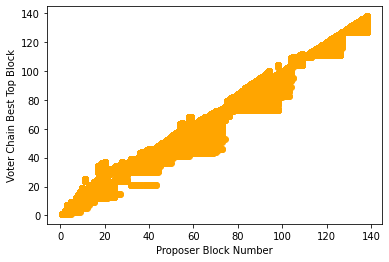

In [25]:
plt.scatter(proposerBlockNumbersArray, voterChainBestTopBlocksArray, c ="orange")
 
# To show the plot
plt.xlabel("Proposer Block Number")
plt.ylabel("Voter Chain Best Top Block")
plt.show()

In [26]:
firstTimeStamp = df['Timestamp - Creation'][0]

proposerBlocksCoordinates = [[],[]]
proposerBlocksMinedOnlyCoordinates = [[],[]]
proposerBlockDownloadedOnlyCoordinates = [[],[]]

with open(user_input, 'r') as f:
    for line in f:
        if "BENCHMARKING:" not in line:
            continue
        benchmarkSubstrings = line[line.find("BENCHMARKING"):-1].split(':')
        dateTimeString = line.split('[')[0][:-1]
        timestamp = getTimestamp(dateTimeString)
        event = benchmarkSubstrings[1]
        blockNumber = int(benchmarkSubstrings[3])
        if event == ProposerBlockMined:
            proposerBlocksCoordinates[0].append(blockNumber)
            proposerBlocksCoordinates[1].append((timestamp-firstTimeStamp)/1000)
            proposerBlocksMinedOnlyCoordinates[0].append(blockNumber)
            proposerBlocksMinedOnlyCoordinates[1].append((timestamp-firstTimeStamp)/1000)
        if event == ValidProposerBlockDownloaded:
            proposerBlocksCoordinates[0].append(blockNumber)
            proposerBlocksCoordinates[1].append((timestamp-firstTimeStamp)/1000)
            proposerBlockDownloadedOnlyCoordinates[0].append(blockNumber)
            proposerBlockDownloadedOnlyCoordinates[1].append((timestamp-firstTimeStamp)/1000)
f.close()


voterChainsCoordinates = []
for i in range(0,100):
    voterChainsCoordinates.append([[],[]])

with open(user_input, 'r') as f:
    for line in f:
        if "VOTERCHAINHEALTH:" not in line:
            continue
        benchmarkSubstrings = line[line.find("VOTERCHAINHEALTH"):-1].split(':')
        dateTimeString = line.split('[')[0][:-1]
        timestamp = getTimestamp(dateTimeString)
        voterChainBestTopBlock = int(benchmarkSubstrings[4])
        voterChainIdx = int(benchmarkSubstrings[2])
        voterChainsCoordinates[voterChainIdx][0].append(voterChainBestTopBlock)
        voterChainsCoordinates[voterChainIdx][1].append((timestamp-firstTimeStamp)/1000)
f.close()

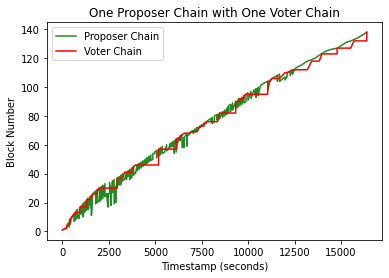

In [27]:
voterChainToSee = 42

plt.plot(proposerBlocksCoordinates[1], proposerBlocksCoordinates[0], c ="forestgreen", label="Proposer Chain")
plt.plot(voterChainsCoordinates[voterChainToSee][1], voterChainsCoordinates[voterChainToSee][0], c="red", label="Voter Chain") 
plt.legend(loc="upper left")

 
# To show the plot
plt.title("One Proposer Chain with One Voter Chain")
plt.xlabel("Timestamp (seconds)")
plt.ylabel("Block Number")
plt.show()

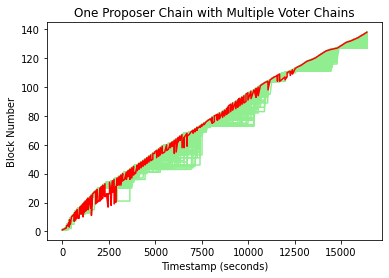

In [32]:
numberOfChainsToSee = 100

for i in range(0,numberOfChainsToSee):
    plt.plot(voterChainsCoordinates[i][1], voterChainsCoordinates[i][0], c="lightgreen", label="Voter Chain")

plt.plot(proposerBlocksCoordinates[1], proposerBlocksCoordinates[0], c ="red", label="Proposer Chain") 

# To show the plot
plt.title("One Proposer Chain with Multiple Voter Chains")
plt.xlabel("Timestamp (seconds)")
plt.ylabel("Block Number")
plt.show()

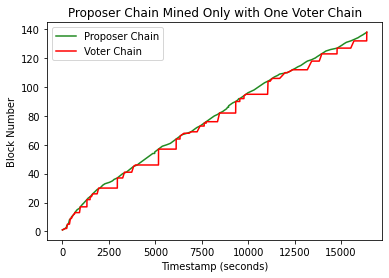

In [29]:
voterChainToSee = 42

plt.plot(proposerBlocksMinedOnlyCoordinates[1], proposerBlocksMinedOnlyCoordinates[0], c ="forestgreen", label="Proposer Chain")
plt.plot(voterChainsCoordinates[voterChainToSee][1], voterChainsCoordinates[voterChainToSee][0], c="red", label="Voter Chain") 
plt.legend(loc="upper left")

 
# To show the plot
plt.title("Proposer Chain Mined Only with One Voter Chain")
plt.xlabel("Timestamp (seconds)")
plt.ylabel("Block Number")
plt.show()

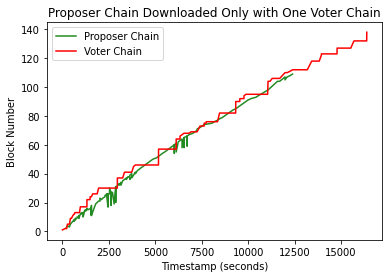

In [30]:
voterChainToSee = 42

plt.plot(proposerBlockDownloadedOnlyCoordinates[1], proposerBlockDownloadedOnlyCoordinates[0], c ="forestgreen", label="Proposer Chain")
plt.plot(voterChainsCoordinates[voterChainToSee][1], voterChainsCoordinates[voterChainToSee][0], c="red", label="Voter Chain") 
plt.legend(loc="upper left")

 
# To show the plot
plt.title("Proposer Chain Downloaded Only with One Voter Chain")
plt.xlabel("Timestamp (seconds)")
plt.ylabel("Block Number")
plt.show()

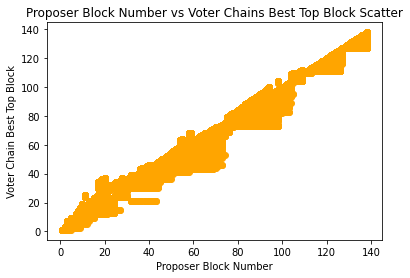

In [31]:
plt.scatter(proposerBlockNumbersArray, voterChainBestTopBlocksArray, c ="orange")
 
# To show the plot
plt.title("Proposer Block Number vs Voter Chains Best Top Block Scatter")
plt.xlabel("Proposer Block Number")
plt.ylabel("Voter Chain Best Top Block")
plt.show()